In [5]:

MAP_SIZE_PIXELS         = 500
MAP_SIZE_METERS         = 12
LIDAR_DEVICE            = '/dev/ttyUSB0'


# Ideally we could use all 250 or so samples that the RPLidar delivers in one 
# scan, but on slower computers you'll get an empty map and unchanging position
# at that rate.
MIN_SAMPLES   = 200

from breezyslam.algorithms import RMHC_SLAM
from breezyslam.sensors import RPLidarA1 as LaserModel
# from roboviz import MapVisualizer

if __name__ == '__main__':

    # Connect to Lidar unit
    lidar = Lidar(LIDAR_DEVICE)

    # Create an RMHC SLAM object with a laser model and optional robot model
    slam = RMHC_SLAM(LaserModel(), MAP_SIZE_PIXELS, MAP_SIZE_METERS)

    # Set up a SLAM display
#     viz = MapVisualizer(MAP_SIZE_PIXELS, MAP_SIZE_METERS, 'SLAM')

    # Initialize an empty trajectory
    trajectory = []

    # Initialize empty map
    mapbytes = bytearray(MAP_SIZE_PIXELS * MAP_SIZE_PIXELS)

    # Create an iterator to collect scan data from the RPLidar
    iterator = lidar.iter_scans()

    # We will use these to store previous scan in case current scan is inadequate
    previous_distances = None
    previous_angles    = None

    # First scan is crap, so ignore it
    next(iterator)

    while True:

        # Extract (quality, angle, distance) triples from current scan
        items = [item for item in next(iterator)]

        # Extract distances and angles from triples
        distances = [item[2] for item in items]
        angles    = [item[1] for item in items]

        # Update SLAM with current Lidar scan and scan angles if adequate
        if len(distances) > MIN_SAMPLES:
            slam.update(distances, scan_angles_degrees=angles)
            previous_distances = distances.copy()
            previous_angles    = angles.copy()

        # If not adequate, use previous
        elif previous_distances is not None:
            slam.update(previous_distances, scan_angles_degrees=previous_angles)

        # Get current robot position
        x, y, theta = slam.getpos()

        # Get current map bytes as grayscale
        slam.getmap(mapbytes)

        # Display map and robot pose, exiting gracefully if user closes it
#         if not viz.display(x/1000., y/1000., theta, mapbytes):
#             exit(0)
 
    # Shut down the lidar connection
    lidar.stop()
    lidar.disconnect()


RPLidarException: Wrong body size

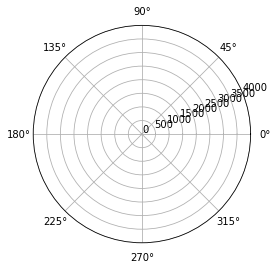

/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [4]:
#!/usr/bin/env python3
'''Animates distances and measurment quality'''
from adafruit_rplidar import RPLidar
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

PORT_NAME = '/dev/ttyUSB0'
DMAX = 4000
IMIN = 0
IMAX = 50

def update_line(num, iterator, line):
    scan = next(iterator)
    offsets = np.array([(np.radians(meas[1]), meas[2]) for meas in scan])
    line.set_offsets(offsets)
    intens = np.array([meas[0] for meas in scan])
    line.set_array(intens)
    return line,

def run():
    lidar = RPLidar(None,PORT_NAME)
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')
    line = ax.scatter([0, 0], [0, 0], s=5, c=[IMIN, IMAX],
                           cmap=plt.cm.Greys_r, lw=0)
    ax.set_rmax(DMAX)
    ax.grid(True)

    iterator = lidar.iter_scans()
    ani = animation.FuncAnimation(fig, update_line,
        fargs=(iterator, line), interval=50)
    plt.show()
    lidar.stop()
    lidar.disconnect()


run()